# Comparison between Different HAT Mask Initialization/Scaling Methods

This file aims investigate the effect of different HAT mask initialization/scaling methods on the convergence and regularization of HAT networks.

The mask initialization/scaling methods are:
- Normal initialization and linear scaling (proposed in in the paper)
- Dense initialization and cosine scaling

Normal initialization initialize the mask attention with a normal distribution with mean 0 and standard deviation 1. Whereas dense initialization initialize the mask attention with constant 1.

## Original HAT Implementation

First, we demonstrate the problem with the original HAT implementation.

The implementation was taken from [Overcoming Catastrophic Forgetting with Hard Attention to the Task](https://github.com/joansj/hat) with minor modifications.

In [1]:
import torch.nn as nn


class OriginalHATNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
        self.efc1 = nn.Embedding(1, 1)
        self.gate = nn.Sigmoid()

    def forward(self, t, x, s=1):
        mask = self.mask(t, s=s)
        h = self.fc1(x)
        y = h * mask.expand_as(h)
        return y, mask

    def mask(self, t, s=1):
        return self.gate(s * self.efc1(t))

    def get_view_for(self, n, masks):
        gfc1 = masks
        if n == "fc1.weight":
            return gfc1.data.view(-1, 1).expand_as(self.fc1.weight)
        elif n == "fc1.bias":
            return gfc1.data.view(-1)
        return None

The dataset has two features (x0 and x1) and one target (y). The features are in normal distribution, and the target is linearly dependent on x0.
We measure the number of batches it takes for the network to converge (i.e. the loss of the test set is less than a threshold).

In [2]:
import torch

num_samples = 1000
num_features = 2

features = torch.randn(num_samples, num_features)
targets = 2 * features[:, 0] + 1
targets = targets.view(-1, 1)

# Split the dataset into train and test sets.
trn_ratio = 0.8
num_train_samples = int(num_samples * trn_ratio)
trn_x, tst_x = features[:num_train_samples], features[num_train_samples:]
trn_y, tst_y = targets[:num_train_samples], targets[num_train_samples:]

# Construct dataloaders for the train and test sets.
trn_dataloader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(trn_x, trn_y),
    shuffle=True,
    batch_size=32,
)
tst_dataloader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(tst_x, tst_y),
    batch_size=32,
)

The training function is also taken from the original implementation.

In [3]:
from hat.constants import (
    DEF_HAT_MAX_TRN_MASK_SCALE,
    DEF_HAT_GRAD_COMP_CLAMP,
    DEF_HAT_ATTN_CLAMP,
)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
convergence_threshold = 0.1
learning_rate = 0.01
momentum = 0.9


def original_convergence_trial(
    model: OriginalHATNetwork,
    max_num_epochs: int,
):
    _model = model.to(device)
    _optimizer = torch.optim.SGD(
        _model.parameters(),
        lr=learning_rate,
        momentum=momentum,
    )
    _criterion = nn.MSELoss()

    def __is_converged() -> bool:
        __tst_loss = 0
        with torch.no_grad():
            for __x, __y in tst_dataloader:
                __pred, _ = _model.forward(
                    torch.as_tensor(0),
                    __x,
                    DEF_HAT_MAX_TRN_MASK_SCALE,
                )
                __tst_loss += _criterion(__pred, __y).item()
        __tst_loss /= len(tst_dataloader)
        return __tst_loss < convergence_threshold

    def __get_trn_mask_scale(
        curr_batch: int,
        max_num_batches: int,
    ) -> float:
        ___min_trn_mask_scale = 1 / DEF_HAT_MAX_TRN_MASK_SCALE
        return (
            DEF_HAT_MAX_TRN_MASK_SCALE - ___min_trn_mask_scale
        ) * curr_batch / max_num_batches + ___min_trn_mask_scale

    # Train the model for `num_epochs` epochs
    _num_batches = 0
    for _ in range(max_num_epochs):
        for __i, (__x, __y) in enumerate(trn_dataloader):
            _optimizer.zero_grad()
            __trn_mask_scale = __get_trn_mask_scale(
                curr_batch=__i,
                max_num_batches=(len(trn_dataloader) - 1),
            )
            __pred, __masks = _model.forward(
                torch.as_tensor(0),
                __x,
                __trn_mask_scale,
            )
            __loss = _criterion(__pred, __y)

            # L1 regularization for the masks
            # From the `criterion()` in the original implementation.
            # At this point, we ignore the regularization term because
            # we are mostly focusing on the initialization of masks.
            # __reg, __cnt = 0, 0
            # for __m in __masks:
            #     __reg += __m.sum()
            #     __cnt += np.prod(__m.size()).item()
            # __reg /= __cnt
            # __loss += __reg

            __loss.backward()

            # Restrict layer gradients in backprop
            # Since this is the first task, there is restriction

            # Compensate embedding gradients
            for __n, __p in _model.named_parameters():
                if __n.startswith("e"):
                    __num = (
                        torch.cosh(
                            torch.clamp(
                                __trn_mask_scale * __p.data,
                                -DEF_HAT_GRAD_COMP_CLAMP,
                                DEF_HAT_GRAD_COMP_CLAMP,
                            )
                        )
                        + 1
                    )
                    __den = torch.cosh(__p.data) + 1
                    __p.grad.data *= (
                        DEF_HAT_MAX_TRN_MASK_SCALE
                        / __trn_mask_scale
                        * __num
                        / __den
                    )

            _num_batches += 1
            _optimizer.step()

            # Constrain embeddings
            for __n, __p in _model.named_parameters():
                if __n.startswith("e"):
                    __p.data = torch.clamp(
                        __p.data,
                        -DEF_HAT_ATTN_CLAMP,
                        DEF_HAT_ATTN_CLAMP,
                    )

            if __is_converged():
                return _num_batches
    return None

Now let's train multiple model instances and see how many batches it takes for the model to converge (or not).

In [4]:
import numpy as np

num_trials = 100
max_num_epochs = 100

original_hat_num_batches = [
    original_convergence_trial(OriginalHATNetwork(), max_num_epochs)
    for _ in range(num_trials)
]
if None in original_hat_num_batches:
    __num_failed_trials = original_hat_num_batches.count(None)
    print(
        f"{__num_failed_trials} out of {num_trials} trials "
        f"failed to converge in the given number of epochs."
    )
    original_hat_num_batches.remove(None)
original_hat_num_batches = np.array(original_hat_num_batches)
print(
    f"Original HAT model converged in "
    f"{original_hat_num_batches.mean():.2f} batches on average."
)

Original HAT model converged in 86.53 batches on average.


Note that the simple network takes absurd number of batches to converge.

This is due to the random initialization of the model parameters.
If the weight of x0 and bias is negative at the beginning, the model will likely to shut down the hard attention due to negative correlation between input and the output. This will lead to the model not being able to learn anything unless the mask scale is very small, which only happens at the beginning of each epoch.
So essentially, the first few epochs are wasted except for the every beginning of each epoch when the mask scale is very small, if the model is initialized with wrong direction.

To verify this, we can try to train the model with positive weight for x0 and bias.

In [5]:
modified_original_hat_num_batches = []
for _ in range(num_trials):
    _model = OriginalHATNetwork()
    _model.fc1.weight.data[0, 0] = torch.abs(_model.fc1.weight.data[0, 0])
    _model.fc1.bias.data = torch.abs(_model.fc1.bias.data)
    modified_original_hat_num_batches.append(
        original_convergence_trial(_model, max_num_epochs)
    )
if None in original_hat_num_batches:
    __num_failed_trials = modified_original_hat_num_batches.count(None)
    print(
        f"{__num_failed_trials} out of {num_trials} trials "
        f"failed to converge in the given number of epochs."
    )
    modified_original_hat_num_batches.remove(None)
modified_original_hat_num_batches = np.array(modified_original_hat_num_batches)
print(
    f"Original HAT model converged in "
    f"{modified_original_hat_num_batches.mean():.2f} batches on average."
)

Original HAT model converged in 13.29 batches on average.


## Solution

The reason for such slow convergence is because the model is training the weight and the attention at the same time.
If the random initialization of the weight is bad, the attention might shut down, which in turn makes the weight almost un-trainable for the rest of the epoch.

Note that this is less of a problem if the model is over-parameterized, because the chance of all the parameters being initialized to bad values is very low.
However, in the case of continual learning, we might run into this problem when there are too many tasks to learn.
The later tasks might not have the luxury of having a large number of trainable parameters.

The solution is to train the weight first so that the weights are in the right direction.
Then, we can train the attention to gradually mask out the irrelevant features. And finally, we can train the weight again to fine-tune the model with binary attention masks.

To achieve this, we need to initialize the attention so that all weights are trainable at the beginning.
And we need to modify the scale of the attention masks so that it's high at the beginning and the end, and low in the middle.

We propose dense initialization for the attention masks and cosine scaling for the attention masks.
Dense initialization means that we initialize the attention masks with a value of 1.
And cosine scaling means that we scale the attention masks with a cosine function.
Here is a visualization of the cosine scaling.

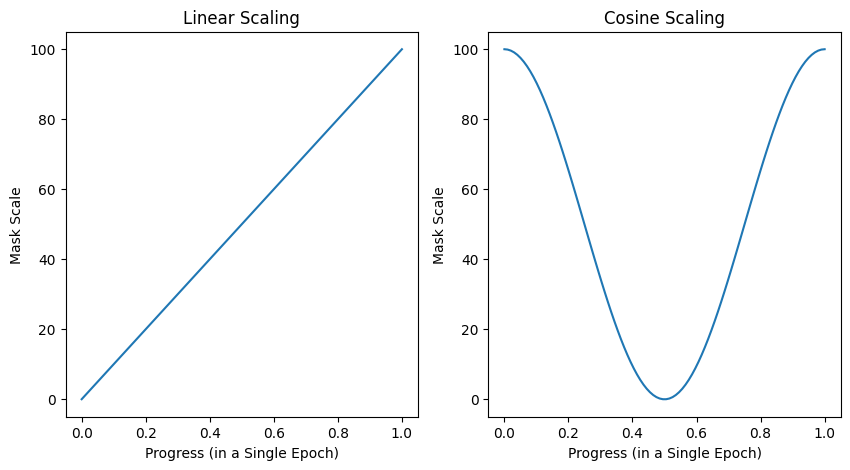

In [6]:
# Visualizing different mask scaling methods
import matplotlib.pyplot as plt

from hat.utils import get_hat_mask_scale

progress = np.linspace(0, 1, 100)
linear_scale = np.array(
    [
        get_hat_mask_scale(
            "linear",
            progress=__p,
        )
        for __p in progress
    ]
)
cosine_scale = np.array(
    [
        get_hat_mask_scale(
            "cosine",
            progress=__p,
        )
        for __p in progress
    ]
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(progress, linear_scale)
ax1.set_title("Linear Scaling")
ax1.set_xlabel("Progress (in a Single Epoch)")
ax1.set_ylabel("Mask Scale")
ax2.plot(progress, cosine_scale)
ax2.set_title("Cosine Scaling")
ax2.set_xlabel("Progress (in a Single Epoch)")
ax2.set_ylabel("Mask Scale")
plt.show()

## On the Convergence of HAT Networks

Now let's test the convergence of the HAT network with the proposed solution v.s. the original approach, implemented with this library.

The network has three different configurations:
- Input mask only
- Output mask only
- Input and output mask

In [7]:
# Create a function that trains a model for `num_epochs` epochs
# and returns the number of batches it takes to converge.
# If the model fails to converge, return None.
def convergence_trial(
    model: nn.Module,
    max_num_epochs: int,
) -> int:
    _model = model.to(device)
    _optimizer = torch.optim.SGD(
        _model.parameters(),
        lr=learning_rate,
        momentum=momentum,
    )
    _criterion = nn.MSELoss()

    def __is_converged() -> bool:
        tst_loss = 0
        with torch.no_grad():
            for __x, __y in tst_dataloader:
                try:
                    __pred = _model.forward(__x, None)
                except TypeError:
                    __pred = _model.forward(__x)
                __loss = _criterion(__pred, __y)
                tst_loss += __loss.item()
        tst_loss /= len(tst_dataloader)
        return tst_loss < convergence_threshold

    # Train the model for `num_epochs` epochs
    num_batches = 0
    for _ in range(max_num_epochs):
        for __i, (__x, __y) in enumerate(trn_dataloader):
            _optimizer.zero_grad()
            # Progress is required for the HAT mask scaling method
            __progress = __i / (len(trn_dataloader) - 1)
            try:
                __pred = _model.forward(__x, __progress)
            except TypeError:
                __pred = _model.forward(__x)
            __loss = _criterion(__pred, __y)
            __loss.backward()
            num_batches += 1
            _optimizer.step()
            if __is_converged():
                return num_batches
    return None

In [8]:
# Check how many epochs the baseline model (no masks) takes to converge
baseline_num_batches = [
    convergence_trial(nn.Linear(2, 1).to(device), max_num_epochs)
    for _ in range(num_trials)
]
if None in baseline_num_batches:
    __num_failed_trials = baseline_num_batches.count(None)
    print(
        f"{__num_failed_trials} out of {num_trials} trials "
        f"failed to converge in the given number of epochs."
    )
    baseline_num_batches.remove(None)
baseline_num_batches = np.array(baseline_num_batches)
print(
    f"Original HAT model converged in "
    f"{baseline_num_batches.mean():.2f} batches on average."
)

Original HAT model converged in 12.66 batches on average.


In [9]:
from hat import HATConfig, HATPayload
from hat.modules import HATLinear, HATMasker
from hat.utils import get_hat_mask_scale


class HATNetwork(nn.Module):
    def __init__(
        self,
        num_features: int,
        input_mask: bool,
        output_mask: bool,
        init_strat: str,
        scaling_strat: str,
    ):
        super().__init__()
        self.hat_config = HATConfig(
            num_tasks=1,
            init_strat=init_strat,
        )
        self.input_mask = (
            HATMasker(
                num_features=num_features,
                hat_config=self.hat_config,
            )
            if input_mask
            else nn.Identity()
        )
        self.linear = (
            HATLinear(
                in_features=num_features,
                out_features=1,
                hat_config=self.hat_config,
            )
            if output_mask
            else nn.Linear(num_features, 1)
        )
        self.scaling_strat = scaling_strat
        self.mask_scale = None

    def forward(self, features, progress):
        _mask_scale = (
            get_hat_mask_scale(
                strat=self.scaling_strat,
                max_trn_mask_scale=self.hat_config.max_trn_mask_scale,
                progress=progress,
            )
            if progress is not None
            else self.hat_config.max_trn_mask_scale
        )
        # Keep track of the mask scale for reference
        self.mask_scale = _mask_scale
        _payload = HATPayload(
            features,
            task_id=0,
            mask_scale=_mask_scale,
        )
        _payload = self.input_mask(_payload)
        if isinstance(self.linear, HATLinear):
            return self.linear(_payload).data
        else:
            return self.linear(_payload.data)

In [10]:
# Iterate over different configurations and compare the results
results = []
configs = [
    (__input_mask, __output_mask, __init_strat, __scaling_strat)
    for __input_mask in [False, True]
    for __output_mask in [False, True]
    # for __init_strat in ["normal", "dense"]
    # for __scaling_strat in ["linear", "cosine"]
    for __init_strat, __scaling_strat in zip(
        ["normal", "dense"],  # Default settings
        ["linear", "cosine"],
    )
]
for __input_mask, __output_mask, __init_strat, __scaling_strat in configs:
    if not __input_mask and not __output_mask:
        continue
    __num_batches = [
        convergence_trial(
            HATNetwork(
                2,
                __input_mask,
                __output_mask,
                __init_strat,
                __scaling_strat,
            ).to(device),
            max_num_epochs,
        )
        for _ in range(num_trials)
    ]
    if None in __num_batches:
        __num_failed_trials = __num_batches.count(None)
        __num_batches.remove(None)
        __fail_rate = __num_failed_trials / num_trials
    else:
        __fail_rate = 0
    __num_batches = np.array(__num_batches)
    __avg_num_batches = __num_batches.mean()
    __result = [
        __input_mask,
        __output_mask,
        __init_strat,
        __scaling_strat,
        __avg_num_batches,
        __fail_rate,
    ]
    results.append(__result)

In [11]:
import pandas as pd

result_df = pd.DataFrame(
    results,
    columns=[
        "In Mask",
        "Out Mask",
        "Init Strat",
        "Scaling Strat",
        "Avg Num Batches",
        "Fail Rate",
    ],
)
# result_df["Fail Rate"] = result_df["Fail Rate"].apply(
#     lambda x: f"{100.0 * x:.1f}%"
# )
if result_df["Fail Rate"].max() > 0.0:
    print(
        "Some trials failed to converge in the given number of epochs. "
        "The results are not reliable."
    )
else:
    result_df.drop("Fail Rate", axis=1, inplace=True)
print(
    result_df.to_markdown(
        index=False,
        floatfmt=".2f",
        tablefmt="fancy_outline",
        stralign="center",
        numalign="center",
    )
)

╒═══════════╤════════════╤══════════════╤═════════════════╤═══════════════════╕
│  In Mask  │  Out Mask  │  Init Strat  │  Scaling Strat  │  Avg Num Batches  │
╞═══════════╪════════════╪══════════════╪═════════════════╪═══════════════════╡
│   False   │    True    │    normal    │     linear      │       84.25       │
│   False   │    True    │    dense     │     cosine      │       12.50       │
│   True    │   False    │    normal    │     linear      │      102.81       │
│   True    │   False    │    dense     │     cosine      │       12.70       │
│   True    │    True    │    normal    │     linear      │      175.97       │
│   True    │    True    │    dense     │     cosine      │       12.74       │
╘═══════════╧════════════╧══════════════╧═════════════════╧═══════════════════╛


## Regularization

Dense initialization makes the attention values start at 1.0, so naturally it raises the question: are they as easy to regularize as the baseline model? Because we certainly don't want redundant hard attention masks, which leaves less parameters for later tasks.

Let's find out.

We construct a new dataset where the target `y` is a linear combination of some of the features: `y = x0 - 2*x2 + 3*x4`. Then we compare how long does it take for a HAT model (with input and output masks) to recognize and zero out the redundant attention weights.

In [12]:
num_samples = 1000
num_features = 5

features = torch.randn(num_samples, num_features)
targets = features[:, 0] - 2 * features[:, 2] + 3 * features[:, 4]
targets = targets.view(-1, 1)

# Split the dataset into train and test sets.
trn_ratio = 0.8
num_train_samples = int(num_samples * trn_ratio)
trn_x, tst_x = features[:num_train_samples], features[num_train_samples:]
trn_y, tst_y = targets[:num_train_samples], targets[num_train_samples:]

# Construct dataloaders for the train and test sets.
trn_dataloader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(trn_x, trn_y),
    shuffle=True,
    batch_size=32,
)
tst_dataloader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(tst_x, tst_y),
    batch_size=32,
)

In [13]:
from hat.utils import get_hat_reg_term


def regularization_trial(
    model: nn.Module,
    max_num_epochs: int,
    regularization_factor: float = 1.0,
) -> int:
    _model = model.to(device)
    _optimizer = torch.optim.SGD(
        _model.parameters(),
        lr=learning_rate,
        momentum=momentum,
    )
    _criterion = nn.MSELoss()

    def __is_mask_regularized() -> bool:
        __input_mask = _model.input_mask.get_binary_mask(0)
        __output_mask = _model.linear.masker.get_binary_mask(0)
        # Strict condition
        __input_mask_reg = torch.all(
            __input_mask == torch.BoolTensor([1, 0, 1, 0, 1])
        ).item()
        # Relaxed condition: mask 0, 2, and 4 are all 1
        # __input_mask_reg = __input_mask[0] & __input_mask[2] & __input_mask[4]
        __output_mask_reg = torch.all(
            __output_mask == torch.BoolTensor([1])
        ).item()
        return __input_mask_reg & __output_mask_reg

    # Train the model for `num_epochs` epochs
    _num_batches = 0
    for _ in range(max_num_epochs):
        for __i, (__x, __y) in enumerate(trn_dataloader):
            _optimizer.zero_grad()
            # Progress is required for the HAT mask scaling method
            __progress = __i / (len(trn_dataloader) - 1)
            try:
                __pred = _model.forward(__x, __progress)
            except TypeError:
                __pred = _model.forward(__x)
            __loss = _criterion(__pred, __y)
            __reg = (
                get_hat_reg_term(
                    _model,
                    reg_strat="uniform",
                    task_id=0,
                    mask_scale=_model.mask_scale,
                    forgive_quota=False,
                )
                * regularization_factor
            )
            # print(f"loss: {__loss}; reg: {__reg}")
            __loss += __reg
            __loss.backward()
            _num_batches += 1
            _optimizer.step()
        if __is_mask_regularized():
            return _num_batches
    return None

In [14]:
results = []
for __init_strat, __scaling_strat in zip(
    ["normal", "dense"],  # Default settings
    ["linear", "cosine"],
):
    __num_batches = [
        regularization_trial(
            HATNetwork(
                5,
                True,
                True,
                __init_strat,
                __scaling_strat,
            ).to(device),
            max_num_epochs,
        )
        for _ in range(num_trials)
    ]
    if None in __num_batches:
        __num_failed_trials = __num_batches.count(None)
        __num_batches.remove(None)
        __fail_rate = __num_failed_trials / num_trials
    else:
        __fail_rate = 0
    __num_batches = np.array(__num_batches)
    __avg_num_batches = __num_batches.mean()
    __result = [
        __init_strat,
        __scaling_strat,
        __avg_num_batches,
        __fail_rate,
    ]
    results.append(__result)

In [15]:
result_df = pd.DataFrame(
    results,
    columns=[
        "Init Strat",
        "Scaling Strat",
        "Avg Num Batches",
        "Fail Rate",
    ],
)
result_df["Fail Rate"] = result_df["Fail Rate"].apply(
    lambda x: f"{100.0 * x:.1f}%"
)
print(
    result_df.to_markdown(
        index=False,
        floatfmt=".2f",
        tablefmt="fancy_outline",
        stralign="center",
        numalign="center",
    )
)

╒══════════════╤═════════════════╤═══════════════════╤═════════════╕
│  Init Strat  │  Scaling Strat  │  Avg Num Batches  │  Fail Rate  │
╞══════════════╪═════════════════╪═══════════════════╪═════════════╡
│    normal    │     linear      │      337.25       │    0.0%     │
│    dense     │     cosine      │       25.00       │    0.0%     │
╘══════════════╧═════════════════╧═══════════════════╧═════════════╛


It is clear that dense initialization with cosine scaling strategy works much better for both weight convergence and mask regularization.
Despite the fact that such improvement might not be as significant in bigger networks, it is still worth noting that the dense initialization strategy is more robust to the scaling strategy.

However, dense initialization usually requires more training epochs or greater learning rate so that the masks are properly regularized.
And adjustment to the regularization factor is often required to achieve the desired mask regularization.